In [1]:
from dataclasses import dataclass, asdict
import math
import random
import shortuuid
import typing
import pandas as pd
import subprocess
import os
import shutil
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
from matplotlib import ticker
import itertools
import cProfile
import pymc as pm
import arviz as az


## Simulation

In [2]:
def get_alpha_beta_from_mean_variance(mu, sigma):
    alpha = ((1-mu)/sigma**2 - 1/mu) * (mu)**2
    beta = alpha * (1/mu - 1)
    if np.any(alpha < 0):
        raise Exception(f'alpha < 0, alpha: \n{alpha} \n beta: \n {beta} \n mu \n {mu} \n sigma \n {sigma}')
    # if alpha < 0:
    #     print('mu, sigma:', mu, sigma)
    #     print('alpha, beta: ', alpha, beta)
    return alpha, beta

In [3]:
get_alpha_beta_from_mean_variance(np.array([0.5,0.9]), 0.05)

(array([49.5, 31.5]), array([49.5,  3.5]))

In [4]:
alp, bet = get_alpha_beta_from_mean_variance(np.array([0.5,0.9]), 0.05)
alp, bet
np.random.beta(a = alp, b= bet)

array([0.38132068, 0.94956272])

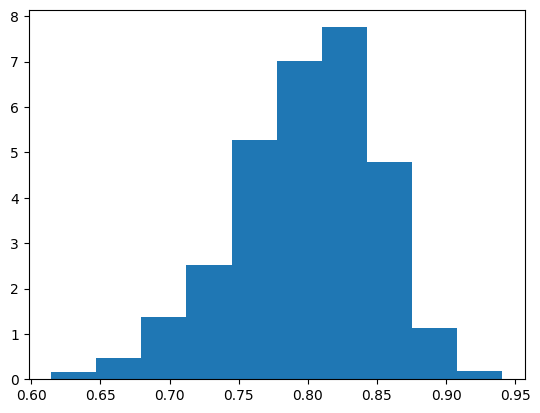

In [5]:
# example usage of function to create beta distribution

mu = 0.8
std = 0.05
alp, bet = get_alpha_beta_from_mean_variance(mu, std)
_ =  plt.hist(np.random.beta(alp, bet, size = 1000), density= True)

In [6]:
def get_random_normalised_vector(n):
    vec = np.random.uniform(0, 1, n)
    vec = vec / np.sum(vec)
    return vec

def add_vectors_and_normalise(vec1, vec2):
    vec = vec1 + vec2
    vec = vec / np.sum(vec)
    return vec

def normalise_vector(vec):
    return (vec / np.sum(vec))

In [7]:
@dataclass
class Artist():
    id : str
    # avg_characteristicness : float # not strictly bounded, but should sit in [0, 1]
    std_characteristicness : float 
    artist_characteristicness_aspects: np.ndarray # should be in [0,1]

    def create_real_ArtImage(self, subject):

        alphas, betas = get_alpha_beta_from_mean_variance(self.artist_characteristicness_aspects, self.std_characteristicness)

        jittered_aspects = np.random.beta(alphas, betas)

        return ArtImage(
            id = f'img~{shortuuid.uuid()}',
            is_ai = False,
            artist = self,
            creator = self,
            subject = subject,
            characteristicness_aspects = jittered_aspects
        )
    
    def to_dict(self):
        return {
            'id': self.id,
            'style_aspects': self.artist_characteristicness_aspects,
            'std_characteristicness': self.std_characteristicness
        }
    
@dataclass
class ArtImage():
    id: str
    is_ai: bool # whether the ArtImage is AI or real
    # characteristicness: float # between 0 and 1
    artist: Artist
    creator: Artist
    subject: str
    characteristicness_aspects: np.ndarray

    def to_dict(self):
        return {
            'id': self.id,
            'is_ai': self.is_ai,
            'artist': self.artist.id,
            'creator': self.creator.id,
            'subject': self.subject,
            'style_aspects': self.characteristicness_aspects
        }

In [8]:
def score_diff_to_probability(diff): 
    return 1 / (1 + math.e**(diff))

In [9]:
@dataclass
class Participant():
    id: str
    skill: float # average value of 5 is reasonable (see calibration section below)
    participant_aspect_weighting: np.ndarray # this should sum to 1; forced below

    def __post_init__(self):
        if np.any(self.participant_aspect_weighting < 0):
            raise Exception(f'weighting is non-negative {self.participant_aspect_weighting}')
        
        self.participant_aspect_weighting = normalise_vector(self.participant_aspect_weighting)

    def compare_two_ArtImages(self, ArtImage1 : ArtImage, ArtImage2 : ArtImage):
        img1_char = np.sum(np.multiply(
            self.participant_aspect_weighting,
            ArtImage1.characteristicness_aspects
        ))

        img2_char = np.sum(np.multiply(
            self.participant_aspect_weighting,
            ArtImage2.characteristicness_aspects
        ))

        diff = img2_char - img1_char
        prob = score_diff_to_probability(self.skill * diff)

        
        diffs = np.multiply(
                ArtImage1.characteristicness_aspects - ArtImage2.characteristicness_aspects,
                self.participant_aspect_weighting
        )

        if random.uniform(0, 1) <= prob:
            chosen =  ArtImage1
            reason = np.argmax(diffs)
        else:
            chosen = ArtImage2
            reason = np.argmin(diffs)
        
        return chosen, reason
    
    def to_dict(self):
        return {
            'id': self.id,
            'skill': self.skill,
            'style_aspect_weights': self.participant_aspect_weighting
        }
        
        

In [10]:
@dataclass
class ImageModel():
    id : str
    ability_to_mimic_style_aspects: np.ndarray # [0,1]
    # this should only rarely be higher than an artist's own characteristicness
    
    def create_ai_ArtImage_matching_image(self, image: ArtImage, std_characteristicness: float) -> ArtImage:
        new_aspects = np.multiply(
            self.ability_to_mimic_style_aspects,
            image.characteristicness_aspects
        )

        alphas, betas = get_alpha_beta_from_mean_variance(new_aspects, std_characteristicness)

        jittered_aspects = np.random.beta(alphas, betas)

        return ArtImage(
            id = f'img~{shortuuid.uuid()}',
            is_ai = True,
            artist = image.artist,
            creator = self,
            subject = image.subject,
            characteristicness_aspects=jittered_aspects
        )

    def to_dict(self):
        return {
            'id': self.id,
            'style_mimicry_abilities': self.ability_to_mimic_style_aspects
        }

## Running overall simulation

- have fixed variations artist aspect vectors
- fixed num_participants

Scenarios:
- models have very similar abilities vs models have very different abilities
- observe variation in participant skills (influence on power)

In [116]:
def generate_data_for_simulation(
        folder_name,
        std_in_participant_aspect_weighting_vectors = 0.02,
        num_participants = 40,
        avg_participant_skill = 5,
        std_participant_skill = 0.5,
        global_latent_aspect_weighting = np.ones(shape=6),
        ARTIST_ASPECT_VECTORS = [
            0.95*np.ones(shape=6)
        ]*4,
        std_real_artist_characteristicness = 0.05,
        N_ARTWORKS_PER_ARTIST = 12, 
        Model_ABILITIES = [
            0.8 * np.ones(shape=6)
        ]*4,
        N_TRIALS_PER_Model_IN_ARTIST_BLOCK = 1,
        num_subjects_per_artist = 1
):
    shutil.rmtree(folder_name, ignore_errors=True)
    os.mkdir(folder_name)

    global_latent_aspect_weighting = normalise_vector(global_latent_aspect_weighting)
    
    artists = [ Artist(
        id=f'art~{shortuuid.uuid()}',
        artist_characteristicness_aspects = vec,
        std_characteristicness=std_real_artist_characteristicness
    ) for vec in ARTIST_ASPECT_VECTORS ]

    real_artworks = []
    for artist in artists:
        subjects = itertools.cycle(range(num_subjects_per_artist))
        for _ in range(N_ARTWORKS_PER_ARTIST):
            real_artworks.append(artist.create_real_ArtImage(subject=next(subjects)))

    models = [ ImageModel(
        id = shortuuid.uuid(),
        ability_to_mimic_style_aspects = vec
    ) for vec in Model_ABILITIES]

    ai_artworks = []
    for real_artwork in real_artworks:
        for Model in models:
            ai_artworks.append(Model.create_ai_ArtImage_matching_image(real_artwork, std_real_artist_characteristicness))

    skills = np.random.normal(
        loc = avg_participant_skill, 
        scale = std_participant_skill, 
        size=num_participants
    )

    aspect_weighting_alphas, aspect_weighting_betas = get_alpha_beta_from_mean_variance(
        global_latent_aspect_weighting, 
        std_in_participant_aspect_weighting_vectors
    )
    
    aspect_weightings = np.random.beta(
        a = aspect_weighting_alphas, 
        b = aspect_weighting_betas, 
        size = (num_participants, len(global_latent_aspect_weighting))
    )

    participants = [
        Participant(
            f'par~{shortuuid.uuid()}', 
            skill = s,
            participant_aspect_weighting=vec
        )
        for s, vec in zip(skills, aspect_weightings)
    ]

    trial_outcomes  = []
    # this can probably be vectorised if it's slow, leave for now
    for participant in participants:
        for artist in artists:
            artist_real_works = itertools.cycle([el for el in real_artworks if el.artist == artist])
            for model in models:
                for _ in range(N_TRIALS_PER_Model_IN_ARTIST_BLOCK):
                    real_artwork = next(artist_real_works)
                    ai_artwork = random.choice([
                        a for a in ai_artworks if a.artist == real_artwork.artist and a.subject == real_artwork.subject and a.creator == model
                    ])

                    chosen_ArtImage, reason = participant.compare_two_ArtImages(real_artwork, ai_artwork)
                    record = {
                        'participant' : participant.id,
                        'real_artwork' : real_artwork.id,
                        'ai_artwork' : ai_artwork.id,
                        'artist' : real_artwork.artist.id,
                        'subject' : real_artwork.subject,
                        'Model' : ai_artwork.creator.id,
                        'real_win': int(chosen_ArtImage == real_artwork),
                        'ai_win' : int(chosen_ArtImage != real_artwork),
                        'winner': chosen_ArtImage.id,
                        'loser': [el for el in [real_artwork.id, ai_artwork.id] if el != chosen_ArtImage.id][0],
                        'reason': reason
                    }
                    trial_outcomes.append(record)


    # participants
    pd.DataFrame([el.to_dict() for el in participants]).to_csv(f'{folder_name}/participants.csv', index=False)

    # artists
    pd.DataFrame([el.to_dict() for el in artists]).to_csv(f'{folder_name}/artists.csv', index=False)

    # artworks
    pd.DataFrame([el.to_dict() for el in real_artworks + ai_artworks]).to_csv(f'{folder_name}/artworks.csv', index=False)

    # models
    pd.DataFrame([el.to_dict() for el in models]).to_csv(f'{folder_name}/models.csv', index=False)

    df = pd.DataFrame(trial_outcomes)

    df.to_csv(f'{folder_name}/outcomes.csv', index=False)

    count_table = df.groupby([
        'participant',
        'real_artwork',
        'ai_artwork',
        'artist',
        'subject',
        'Model',
        'reason'
    ]).sum().reset_index()
    # count_table_r = df.groupby(by=['real_artwork', 'ai_artwork']).sum().reset_index()
    count_table.to_csv(f'{folder_name}/counts.csv', index=False)

In [117]:
generate_data_for_simulation(
    'even_aspect_test', 
    global_latent_aspect_weighting=np.array([1,1,1,1,1,1]),
    Model_ABILITIES=[
        np.array([0.7,0.9,0.9,0.9,0.9,0.9]),
        np.array([0.7,0.7, 0.7, 0.7,0.9,0.9])
    ]
)

## Bayesian method

In [ ]:
def process_count_data_for_bayesian_methods(df):
    all_artworks = pd.unique(df[["real_artwork", "ai_artwork"]].values.ravel())
    art_id_map = {art: i for i, art in enumerate(all_artworks)}

    all_models = pd.unique(df[["Model"]].values.ravel())
    model_id_map = {model: i for i, model in enumerate(all_models)}

    n_players = len(all_artworks)

    rows = []
    for _, row in df.iterrows():
        real_id = art_id_map[row["real_artwork"]]
        ai_id   = art_id_map[row["ai_artwork"]]
        # real wins
        rows += [(real_id, ai_id, model_id)] * int(row["real_win"])
        # ai wins
        rows += [(ai_id, real_id, model_id)] * int(row["ai_win"])

    pairwise = pd.DataFrame(rows, columns=["winner", "loser", 'model'])

    winner = pairwise["winner"].values
    loser  = pairwise["loser"].values

    is_ai = np.array([art in set(df["ai_artwork"]) for art in all_artworks]).astype(int)
    
    return winner, loser, is_ai, n_players

def extract_variables_from_pymc_results(trace, variables_of_interest):
    res_bayesian = az.summary(trace, var_names= variables_of_interest, hdi_prob=0.94)[['mean','hdi_3%','hdi_97%']].rename(
        columns={'hdi_3%': 'lower', 'hdi_97%': 'upper', 'mean':'estimate'}
    )
    res_bayesian['p_value'] = [np.mean(trace.posterior[var].values.flatten() > 0 ) for var in variables_of_interest]
    return res_bayesian

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [characteristicness, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 9 seconds.


,estimate,lower,upper,p_value
beta_ai,-0.268,-2.72,2.069,0.413


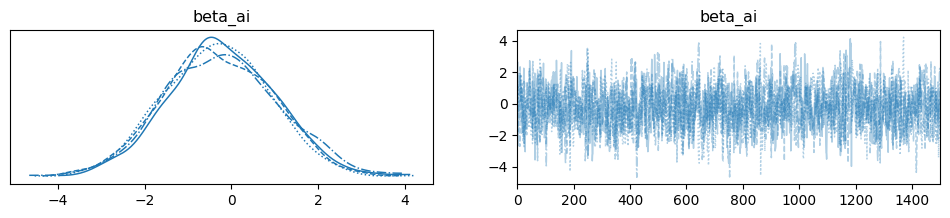

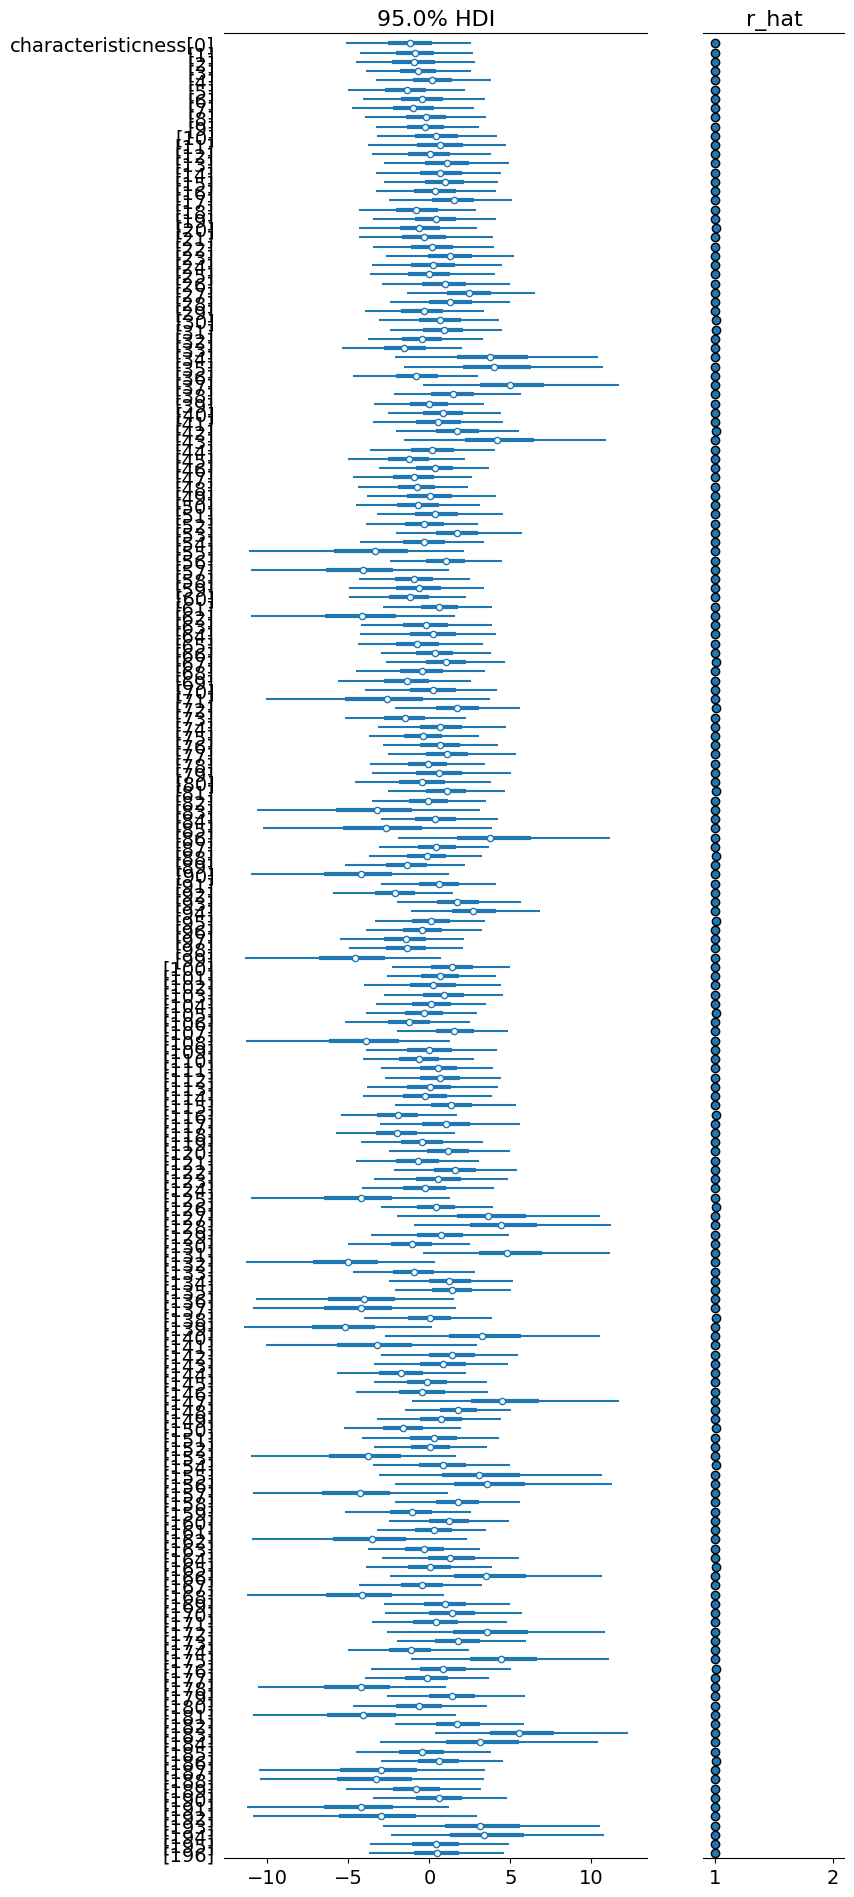

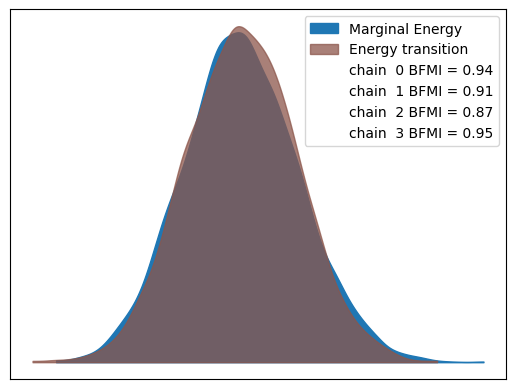

In [ ]:
def run_bayesian_analysis(path_to_data, type = 'basic'):
    df = pd.read_csv(path_to_data)

    winner, loser, is_ai, n_players = process_count_data_for_bayesian_methods(df)

    if type == 'individual_effects':
        with pm.Model() as bt_cov_model:
            characteristicness = pm.Normal("characteristicness", mu=0, sigma=5, shape=n_players)
            characteristicness_centered = characteristicness - pm.math.mean(characteristicness)

            beta_ai = pm.Normal("beta_ai", mu=0, sigma=5)

            logit_p = (
                characteristicness_centered[winner] - characteristicness_centered[loser]
                + beta_ai * (is_ai[winner] - is_ai[loser])
            )
            p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

            pm.Bernoulli("outcome", p=p, observed=np.ones(len(winner)))

            trace = pm.sample(1500, tune=1000, target_accept=0.9, random_seed=42)

            az.plot_trace(trace, var_names = ['beta_ai'])

            az.plot_forest(trace, var_names=["characteristicness"], combined=True, hdi_prob=0.95, r_hat=True);
    elif type == 'basic':
        with pm.Model() as bt_cov_model:
            beta_ai = pm.Normal("beta_ai", mu=0, sigma=1)

            logit_p = (
                beta_ai * (is_ai[winner] - is_ai[loser])
            )
            p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

            pm.Bernoulli("outcome", p=p, observed=np.ones(len(winner)))

            trace = pm.sample(1500, tune=1000, target_accept=0.9, random_seed=42)

            az.plot_trace(trace)

    elif type == 'latent':
        with pm.Model() as bt_cov_model:
            gamma = pm.Uniform('gamma', lower=0, upper = 1, shape= 6)
            gamma_vector = gamma / pm.math.sum(gamma)
            
            beta_ai = pm.Normal("beta_ai", mu=0, sigma=1)
            beta_model = pm.Normal('beta_model', mu=0, sigma=1, )

            logit_p = (
                beta_ai * (is_ai[winner] - is_ai[loser])
            )
            p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

            pm.Bernoulli("outcome", p=p, observed=np.ones(len(winner)))

            trace = pm.sample(1500, tune=1000, target_accept=0.9, random_seed=42)

            az.plot_trace(trace)

    az.plot_energy(trace)

    return extract_variables_from_pymc_results(trace, ['beta_ai'])
    
run_bayesian_analysis("/Users/daxmavy/oxford/art/simulations/data/test/sims/0/counts.csv", True)

## MLE

In [79]:
model.linear.weight.data

tensor([[-8.4873, -8.6605],
        [ 1.8211, -1.1356],
        [-1.5313, -1.1352],
        [ 2.4755,  1.8477],
        [ 2.5424,  3.6779],
        [ 1.5986,  4.2187]])

## Pure multinomial regression only using reason data

In [84]:
# model

model_multinomial = pm.Model()

with model_multinomial:
    num_models = len(np.unique(idx_to_model))
    num_aspects = 6

    beta_model_aspects = pm.Normal('beta_model_aspects', mu = 0, sigma=10, shape = (num_models,num_aspects))

    diff = beta_model_aspects[winners_model] - beta_model_aspects[losers_model]
    
    reason_p = pm.math.softmax(diff, axis=1)

    reason_obs = pm.Categorical(
        'reason_obs',
        p = reason_p,
        observed = reasons
    )
    idata_multinomial = pm.sample(2000,idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_model_aspects]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

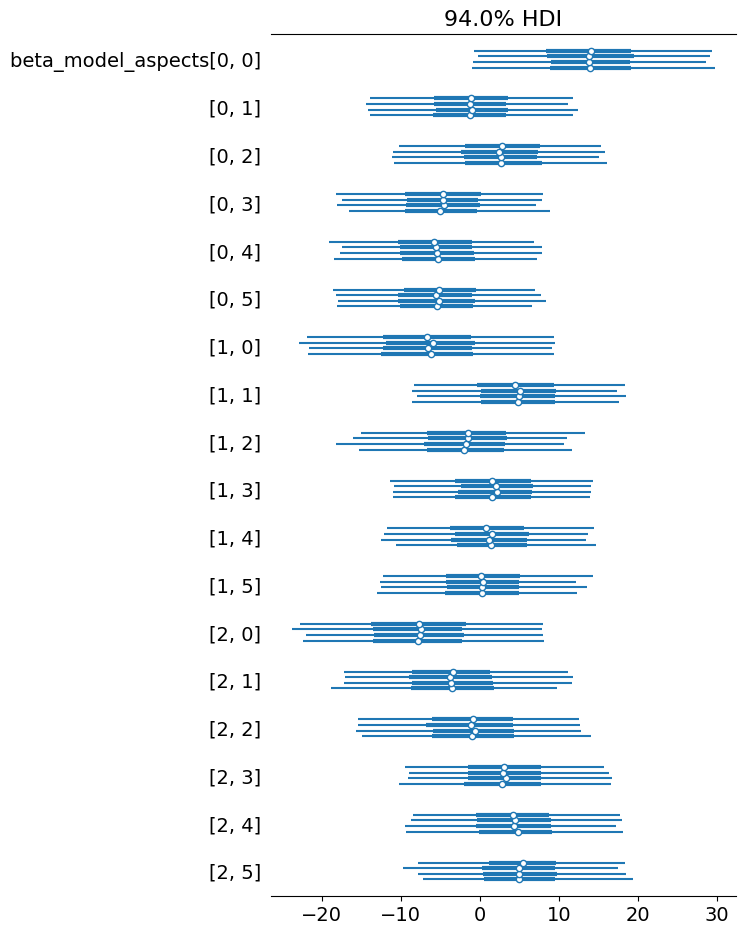

In [85]:
az.plot_forest(idata_multinomial)

In [89]:
from statsmodels.discrete.discrete_model import MNLogit

In [103]:
diff_model_one_hot

array([[-1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.],
       [-1.,

In [113]:
reasons.value_counts()

reason
0    254
5     26
4     24
3     11
1      5
Name: count, dtype: int64

In [114]:
multi_mle = MNLogit(reasons, diff_model_one_hot, check_rank=True).fit(maxiter=30000, method='nm')


Optimization terminated successfully.
         Current function value: 1.024184
         Iterations: 2500
         Function evaluations: 3640


In [105]:
multi_mle.mle_retvals

{'fopt': np.float64(1.0241841467698038),
 'iterations': 2500,
 'fcalls': 3640,
 'warnflag': 0,
 'converged': True}

In [108]:
reasons.value_counts()

reason
0    254
5     26
4     24
3     11
1      5
Name: count, dtype: int64

- influence of participant skill, model skill, participant count on power



In [115]:
multi_mle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 reason   No. Observations:                  320
Model:                        MNLogit   Df Residuals:                      312
Method:                           MLE   Df Model:                            4
Date:                Wed, 19 Nov 2025   Pseudo R-squ.:                 -0.3433
Time:                        13:39:00   Log-Likelihood:                -327.74
converged:                       True   LL-Null:                       -243.97
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
  reason=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3079      0.319      7.225      0.000       1.682       2.934
x2             0.0416      0.231      0.180      0.857      -0.411       0.494
------------------------------------------------------------------------------
  reason=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1810      0.302      7.228      0.000       1.590       2.772
x2             0.0149      0.230      0.065      0.948      -0.435       0.465
------------------------------------------------------------------------------
  reason=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.0564      2.412      3.341      0.001       3.330      12.783
x2             1.7356      0.300      5.795      0.000       1.149       2.323
------------------------------------------------------------------------------
  reason=5       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.8843      2.412      3.269      0.001       3.157      12.611
x2             0.8893      0.274      3.251      0.001       0.353       1.425
==============================================================================
"""

## Bayesian models

In [49]:
# model

model_0 = pm.Model()

with model_0:
    num_models = len(np.unique(idx_to_model))
    num_aspects = 6
    
    # beta_model = pm.Normal('beta_model', mu = 0, sigma = 10, size=num_models)

    # beta_model_aspects = pm.Normal('beta_model_aspects', mu = beta_model[:, None], sigma=10, shape = (num_models,num_aspects))

    beta_model_aspects = pm.Normal('beta_model_aspects', mu = 0, sigma=4, shape = (num_models,num_aspects))
    scaling= pm.HalfNormal('scaling', sigma = 1, shape=1)

    diff = beta_model_aspects[winners_model] - beta_model_aspects[losers_model]

    logit_diff = pm.math.sigmoid(pm.math.sum(diff))

    Y_obs = pm.Bernoulli('Y_obs', p=logit_diff, observed = np.ones(shape=len(bdf)))

    # softmax across the aspects dimension (axis=1) → valid probabilities per obs
    reason_p = pm.math.softmax(scaling * diff, axis=1)

    reason_obs = pm.Categorical(
        'reason_obs',
        p = reason_p,
        observed = reasons
    )

    idata_0 = pm.sample(2000,idata_kwargs={"log_likelihood": True}, nuts={'target_accept': 0.95})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_model_aspects, scaling]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 705 seconds.
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


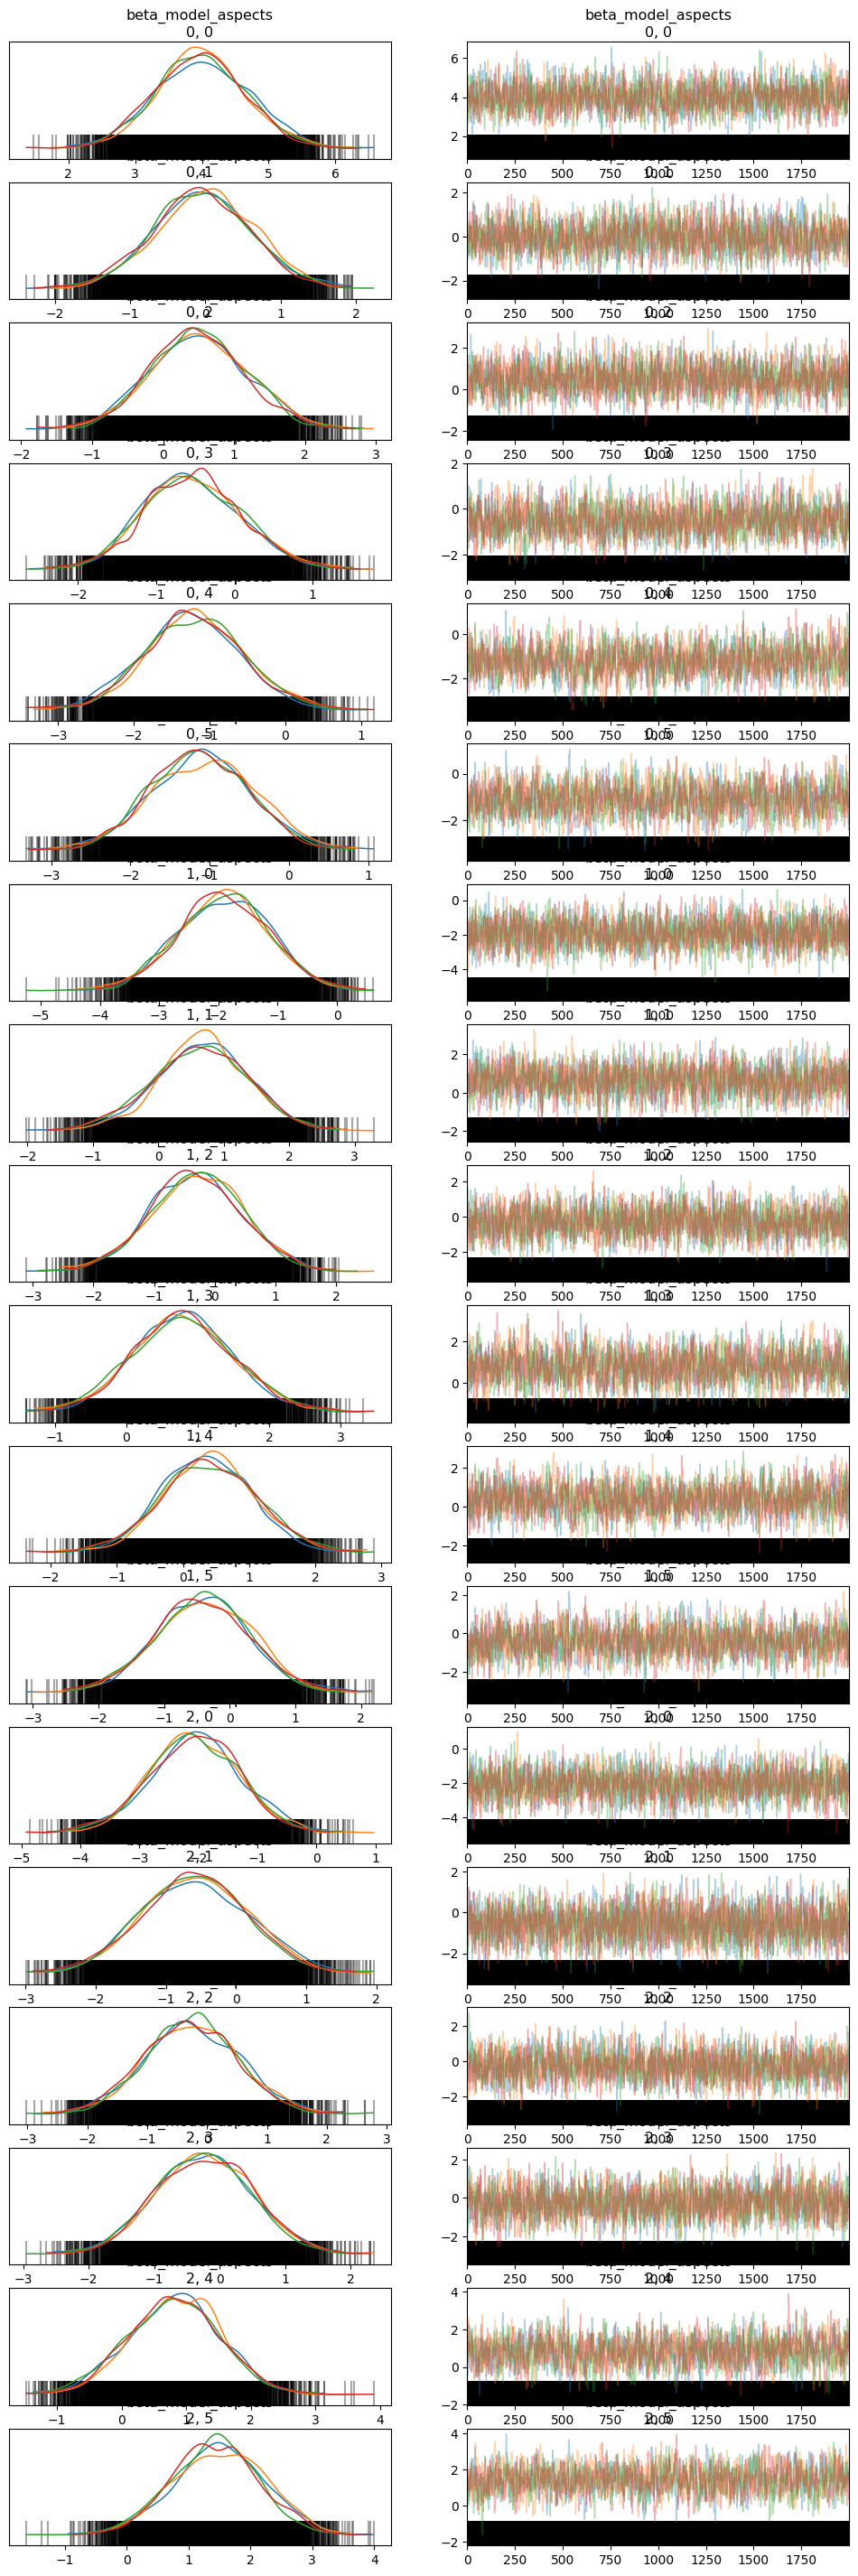

In [31]:
_ = az.plot_trace(idata_0, compact=False)

In [19]:
# model

model_1 = pm.Model()

with model_1:
    num_models = len(np.unique(idx_to_model))
    num_aspects = 6

    aspect_weighting = pm.Uniform('aspect_weighting', lower = 0, upper = 1, size = num_aspects)
    aspect_weighting_normalised = pm.Deterministic('aspect_weighting_normalised', aspect_weighting / pm.math.sum(aspect_weighting))
    
    beta_model = pm.Normal('beta_model', mu = 0, sigma = 10, size=num_models)

    beta_model_aspects = pm.Normal('beta_model_aspects', mu = beta_model[:, None], sigma=10, shape = (num_models,num_aspects))

    char_aspects_winners = beta_model_aspects[winners_model]
    winner_lambda = pm.math.matmul(char_aspects_winners, aspect_weighting_normalised)

    char_aspects_losers = beta_model_aspects[losers_model]
    loser_lambda = pm.math.matmul(char_aspects_losers, aspect_weighting_normalised)

    diff = winner_lambda - loser_lambda

    logit_diff = pm.math.sigmoid(diff) #TODO: huh

    Y_obs = pm.Bernoulli('Y_obs', p=logit_diff, observed = np.ones(shape=len(bdf)))

    # reason_obs = pm.Categorical('reason_obs', p = (char_aspects_winners - char_aspects_losers) * aspect_weighting_normalised, observed=reasons)
    diff_aspects = char_aspects_winners - char_aspects_losers

    # apply aspect weighting (broadcasting across observations)
    # aspect_weighting_normalised has shape (num_aspects,)
    weighted_diff = diff_aspects * aspect_weighting_normalised[None, :]

    # softmax across the aspects dimension (axis=1) → valid probabilities per obs
    reason_p = pm.math.softmax(weighted_diff, axis=1)

    reason_obs = pm.Categorical(
        'reason_obs',
        p = reason_p,
        observed = reasons
    )

    idata_1 = pm.sample(2000,idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aspect_weighting, beta_model, beta_model_aspects]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 156 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/daxmavy/oxford/art/.venv/lib/python3.13/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  warnings.warn(


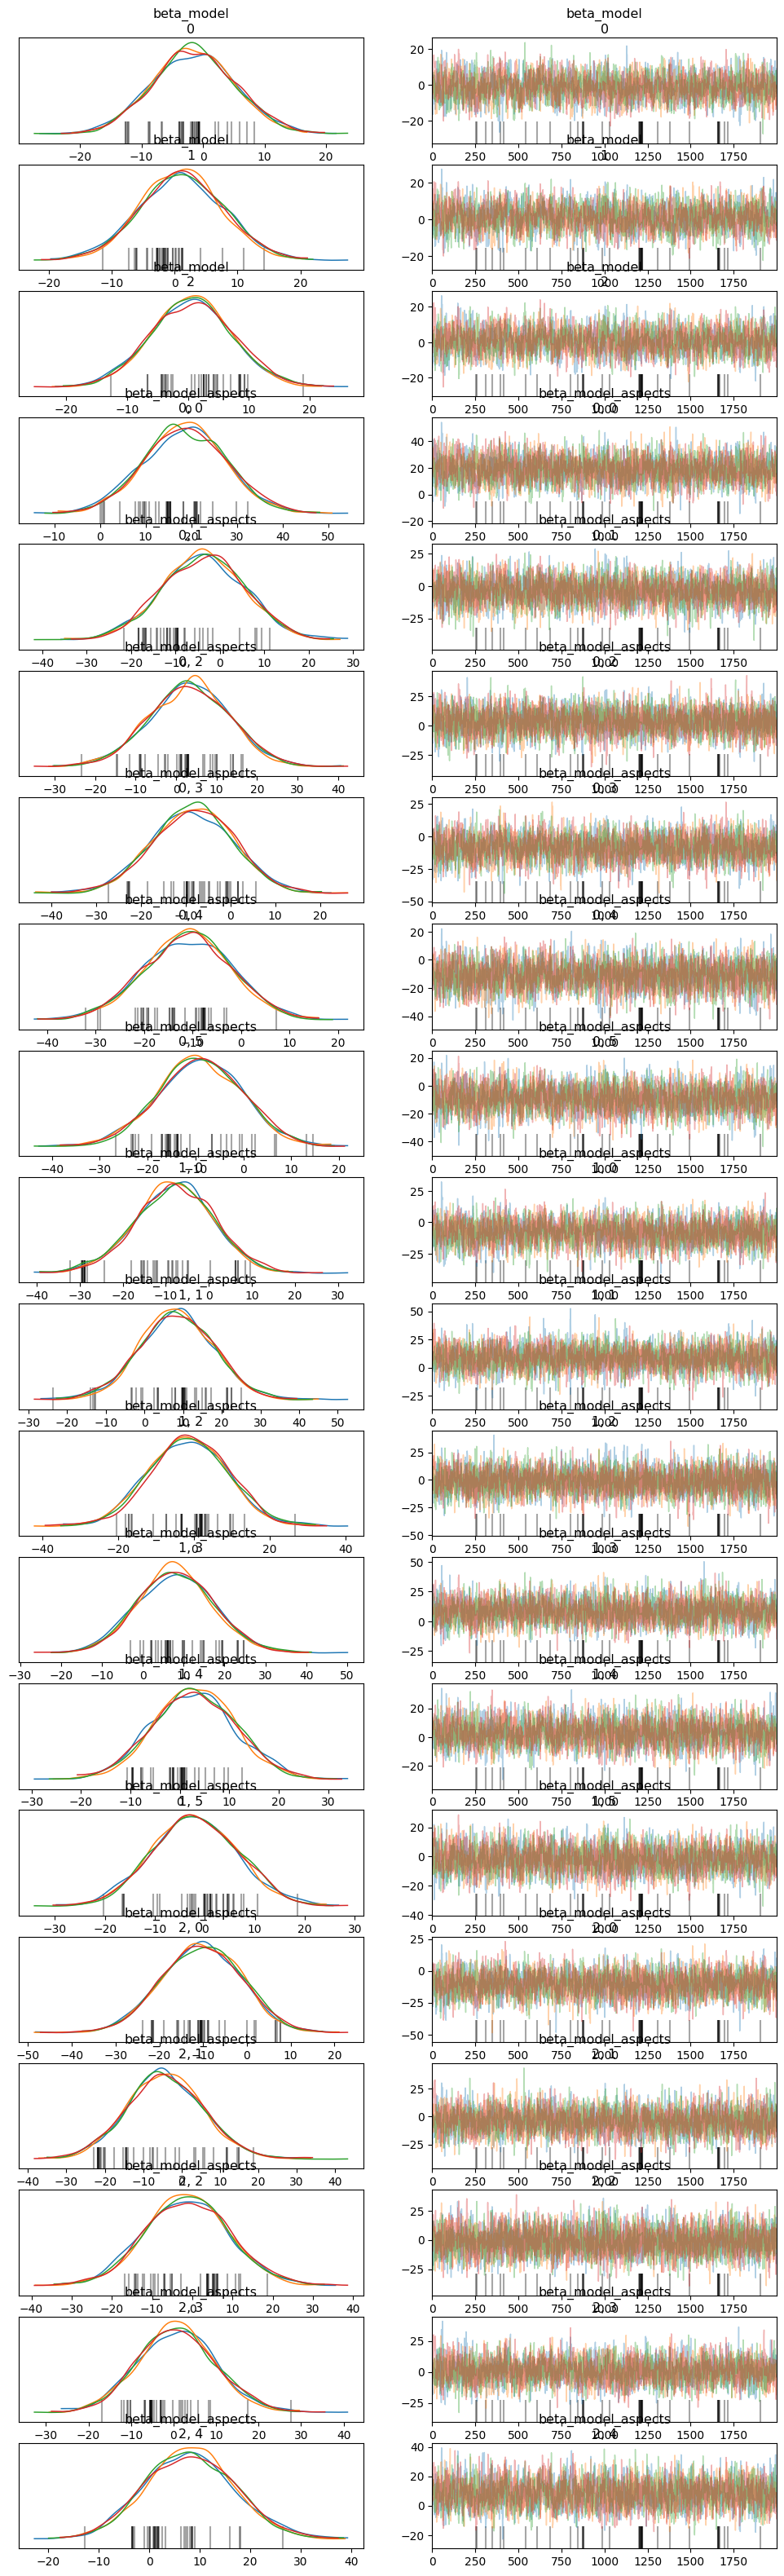

In [23]:
_ = az.plot_trace(idata_1, compact=False, rug=False)

In [ ]:
model_2 = pm.Model()
# without latent weights 

with model_2:
    num_models = len(np.unique(idx_to_model))
    num_aspects = 6

    # aspect_weighting = pm.Uniform('aspect_weighting', lower = 0, upper = 1, size = num_aspects)
    # aspect_weighting_normalised = pm.Deterministic('aspect_weighting_normalised', aspect_weighting / pm.math.sum(aspect_weighting))
    
    beta_model = pm.Normal('beta_model', mu = 0, sigma = 1, size=num_models)

    beta_model_aspects = pm.Normal('beta_model_aspects', mu = beta_model[:, None], sigma=1, shape = (num_models,num_aspects))

    char_aspects_winners = beta_model_aspects[winners_model]
    winner_lambda = pm.math.sum(char_aspects_winners)

    char_aspects_losers = beta_model_aspects[losers_model]
    loser_lambda = pm.math.sum(char_aspects_losers)

    diff = winner_lambda - loser_lambda

    logit_diff = pm.math.sigmoid(diff) #TODO: huh

    Y_obs = pm.Bernoulli('Y_obs', p=logit_diff, observed = np.ones(shape=len(bdf)))

    # reason_obs = pm.Categorical('reason_obs', p = (char_aspects_winners - char_aspects_losers) * aspect_weighting_normalised, observed=reasons)
    diff_aspects = char_aspects_winners - char_aspects_losers

    # softmax across the aspects dimension (axis=1) → valid probabilities per obs
    reason_p = pm.math.softmax(diff_aspects, axis=1)

    reason_obs = pm.Categorical(
        'reason_obs',
        p = reason_p,
        observed = reasons
    )

    idata_2 = pm.sample(2000,idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_model, beta_model_aspects]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.
There were 1346 divergences after tuning. Increase `target_accept` or reparameterize.


In [15]:
model_3 = pm.Model()
# only using beta_ai

with model_3:    
    beta_ai = pm.Normal('beta_model', mu = 0, sigma = 1)

    winner_lambda = idx_to_is_ai[winners]*1*beta_ai

    loser_lambda = idx_to_is_ai[losers]*1*beta_ai

    diff = winner_lambda - loser_lambda

    logit_diff = pm.math.sigmoid(diff) #TODO: huh 1/(1+e^{-x}), so when diff increasess, e^{-x} decreases, so denom decreases, so prob increases

    Y_obs = pm.Bernoulli('Y_obs', p=logit_diff, observed = np.ones(shape=len(bdf)))

    # reason_obs = pm.Categorical('reason_obs', p = (char_aspects_winners - char_aspects_losers) * aspect_weighting_normalised, observed=reasons)
    # diff_aspects = char_aspects_winners - char_aspects_losers

    # # softmax across the aspects dimension (axis=1) → valid probabilities per obs
    # reason_p = pm.math.softmax(diff_aspects, axis=1)

    # reason_obs = pm.Categorical(
    #     'reason_obs',
    #     p = reason_p,
    #     observed = reasons
    # )

    idata_3 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_model]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

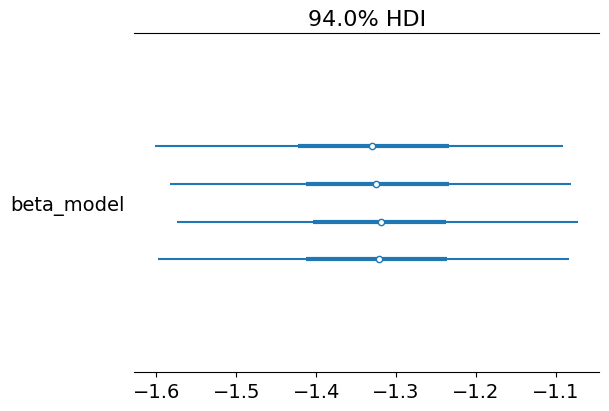

In [16]:
az.plot_forest(idata_3)

/Users/daxmavy/oxford/art/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/daxmavy/oxford/art/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

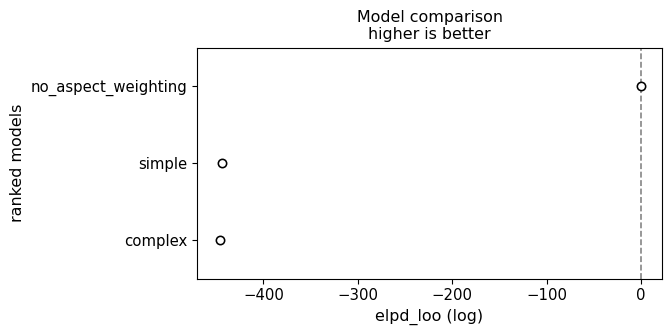

In [ ]:
comp_df = az.compare({
    'complex' : idata_1,
    'no_aspect_weighting': idata_2,
    'simple': idata_3
}, var_name='Y_obs')

az.plot_compare(comp_df)

In [111]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_model[0],0.080,1.163,-2.216,2.180,0.027,0.019,1931.0,2750.0,1.0
beta_model[1],0.229,1.183,-2.132,2.388,0.027,0.019,1900.0,2660.0,1.0
beta_model[2],0.038,1.179,-2.006,2.433,0.026,0.018,2079.0,3255.0,1.0
beta_model[3],-0.216,1.186,-2.412,2.158,0.028,0.020,1858.0,2982.0,1.0
beta_model[4],0.089,1.159,-2.235,2.174,0.027,0.019,1846.0,2610.0,1.0
"beta_model_aspects[0, 0]",-1.284,1.418,-3.902,1.480,0.032,0.020,1963.0,3098.0,1.0
"beta_model_aspects[0, 1]",2.270,1.430,-0.338,5.094,0.034,0.021,1762.0,2799.0,1.0
"beta_model_aspects[0, 2]",-0.639,1.447,-3.348,2.174,0.031,0.022,2218.0,3009.0,1.0
"beta_model_aspects[0, 3]",1.630,1.622,-1.378,4.790,0.031,0.021,2749.0,3778.0,1.0
"beta_model_aspects[0, 4]",-0.376,1.356,-2.924,2.184,0.034,0.020,1614.0,2759.0,1.0


## Running simulation and analysis

In [54]:
p_value_bin_range = np.arange(0,1, 0.01)

def run_simulation_n_times(
        folder_name, 
        N = 100, 
        plot=True, 
        do_simple_regression_no_individual_effects = True,
        do_binomial_no_individual_effect = True,
        do_bayes_individual_effects = True,
        do_bayes_no_individual_effects = True,
        **simulation_args
    ):
    shutil.rmtree(f'data/{folder_name}', ignore_errors = True)
    os.mkdir(f'data/{folder_name}')
    os.mkdir(f'data/{folder_name}/sims')
    os.mkdir(f'data/{folder_name}/analysis')
    os.mkdir(f'data/{folder_name}/plots')
    
    ### Simulation ###
    for i in range(N):
        generate_data_for_simulation(f'data/{folder_name}/sims/{i}', **simulation_args)    

    ### Processing analysis output for R ###

    ### Regression without individual random effects ###
    if do_simple_regression_no_individual_effects:
        subprocess.run([
            'Rscript',
            'model_fit.R',
            f'data/{folder_name}/sims',
            f'data/{folder_name}/analysis',
            str(N)           # number of sims
        ])

        print('R, regression')

        df_regression_fixed = pd.read_csv(f'data/{folder_name}/analysis/results_fixed.csv')
        df_regression_fixed.estimate.hist(bins=10)
        plt.title('Distribution of AI coefficient estimate (regression, no individual scores)')
        plt.xlabel('$\\beta$ coefficient value for `is_ai` indicator variable')
        plt.savefig(f'data/{folder_name}/plots/estimate_hist_regression.png')
        if plot:
            plt.show()
        else:
            plt.close()
        df_regression_fixed.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (df_regression_fixed.p_value.max() + 0.05)])
        prop_significant_regression = (df_regression_fixed.p_value < 0.05).mean()
        plt.title(f'Distribution of p value ({prop_significant_regression:.0%} of simulations stat. sig.) (regression, no individual scores)', wrap=True)
        plt.xlabel('p value')
        plt.axvline(0.05, color='red', linestyle='--')
        plt.savefig(f'data/{folder_name}/plots/p_value_hist_regression.png')
        if plot:
            plt.show()
        else:
            plt.close()

        ### Regression with individual random effects ###
        
        # This doesn't work right now because of small sample size causing separability in data (only AI/real wins for an observation)

        # df_regression_random = pd.read_csv(f'data/{folder_name}/analysis/results_random.csv')
        # df_regression_random.estimate.hist(bins=10)
        # plt.title('Distribution of AI coefficient estimate (regression w. individual scores)')
        # plt.xlabel('$\\beta$ coefficient value for `is_ai` indicator variable')
        # plt.savefig(f'data/{folder_name}/plots/estimate_hist_regression.png')
        # if plot:
        #     plt.show()
        # else:
        #     plt.close()
        # df_regression_random.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (df_regression_random.p_value.max() + 0.05)])
        # prop_significant_regression = (df_regression_random.p_value < 0.05).mean()
        # plt.title(f'Distribution of p value ({prop_significant_regression:.0%} of simulations stat. sig.) (regression w. individual scores)', wrap=True)
        # plt.xlabel('p value')
        # plt.axvline(0.05, color='red', linestyle='--')
        # plt.savefig(f'data/{folder_name}/plots/p_value_hist_regression.png')
        # if plot:
        #     plt.show()
        # else:
        #     plt.close()

    ### PYTHON ANALYESES ###

    ### Simple binomial approach ### 

    if do_binomial_no_individual_effect:
        print('binomial')

        simple_binomial_test_res = []
        for i in range(N):
            counts = pd.read_csv(f'data/{folder_name}/sims/{i}/counts.csv').set_index(['real_artwork', 'ai_artwork'])[['real_win', 'ai_win']].sum()
            res = st.binomtest(k = counts.loc['ai_win'], n = counts.sum(), p=0.5)
            # print(counts.loc['ai_win'], counts.sum())
            simple_binomial_test_res.append([res.proportion_ci().low, res.statistic, res.proportion_ci().high, res.pvalue])
        binom_res_df = pd.DataFrame(simple_binomial_test_res, columns = ['lower', 'estimate', 'upper', 'p_value' ])
        
        binom_res_df.to_csv(f'data/{folder_name}/analysis/binomial_results.csv', index=False)

        ### Plotting binomial approach ###
        binom_res_df.estimate.hist(bins=10)
        plt.title('Distribution of AI coefficient estimate (binomial)')
        plt.xlabel('proportion of trials won by AI')
        plt.savefig(f'data/{folder_name}/plots/estimate_hist_binomial.png')
        if plot:
            plt.show()
        else:
            plt.close()
        binom_res_df.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (binom_res_df.p_value.max() + 0.05)])
        prop_significant_binom = (binom_res_df.p_value < 0.05).mean()
        plt.title(f'Distribution of p value ({prop_significant_binom:.0%} of simulations stat. sig.) (binomial)', wrap=True)
        plt.axvline(0.05, color='red', linestyle='--')
        plt.xlabel('p value')
        plt.savefig(f'data/{folder_name}/plots/p_value_hist_binomial.png')
        if plot:
            plt.show()
        else:
            plt.close()

    ### Bayesian approach with individual regression effects ###

    if do_bayes_individual_effects:
        print('Bayesian with per-image fixed effect')
        
        bayesian_individual_effect_result = pd.concat([run_bayesian_analysis(
            f'data/{folder_name}/sims/{i}/counts.csv', with_individual_effects=True
        ) for i in range(N)])
        bayesian_individual_effect_result.to_csv(f'data/{folder_name}/analysis/bayesian_individual_results.csv')

        bayesian_individual_effect_result.estimate.hist(bins=10)
        plt.title('Distribution of AI coefficient estimate (Bayesian w/ individual effects)', wrap=True)
        plt.xlabel('estimate of $\\beta$ coefficient for being AI')
        plt.savefig(f'data/{folder_name}/plots/estimate_hist_bayesian_ind.png')
        if plot:
            plt.show()
        else:
            plt.close()
        bayesian_individual_effect_result.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (bayesian_individual_effect_result.p_value.max() + 0.05)])
        prop_significant_ind_bayes = (bayesian_individual_effect_result.p_value < 0.05).mean()
        plt.title(f'Distribution of p value ({prop_significant_ind_bayes:.0%} of simulations stat. sig.) (Bayesian w. ind effects)', wrap=True)
        plt.axvline(0.05, color='red', linestyle='--')
        plt.xlabel('p value')
        plt.savefig(f'data/{folder_name}/plots/p_value_hist_bayesian_ind.png')
        if plot:
            plt.show()
        else:
            plt.close()

    ## Bayesian approach without individual regression effects
    if do_bayes_no_individual_effects:
        print('Bayesian without per-image fixed effect')

        bayesian_non_individual_effect_result = pd.concat([run_bayesian_analysis(
            f'data/{folder_name}/sims/{i}/counts.csv', with_individual_effects=False
        ) for i in range(N)])
        bayesian_non_individual_effect_result.to_csv(f'data/{folder_name}/analysis/bayesian_individual_results.csv')

        bayesian_non_individual_effect_result.estimate.hist(bins=10)
        plt.title('Distribution of AI coefficient estimate (Bayesian w/out individual effects)', wrap=True)
        plt.xlabel('proportion of trials won by AI')
        plt.savefig(f'data/{folder_name}/plots/estimate_hist_bayesian_not_ind.png')
        if plot:
            plt.show()
        else:
            plt.close()
        binom_res_df.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (bayesian_non_individual_effect_result.p_value.max() + 0.05)])
        prop_significant_non_ind_bayes = (bayesian_non_individual_effect_result.p_value < 0.05).mean()
        plt.title(f'Distribution of p value ({prop_significant_non_ind_bayes:.0%} of simulations stat. sig.) (Bayesian w/out ind effects)', wrap=True)
        plt.axvline(0.05, color='red', linestyle='--')
        plt.xlabel('p value')
        plt.savefig(f'data/{folder_name}/plots/p_value_hist_bayesian_not_ind.png')
        if plot:
            plt.show()
        else:
            plt.close()
    
    return prop_significant_regression, prop_significant_binom#, prop_significant_ind_bayes, prop_significant_non_ind_bayes

Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects
3: Ability modelled by predictors but no random effects
4: Ability modelled by predictors but no random effects
5: Ability modelled by predictors but no random effects
R, regression


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 
3: Ability modelled by predictors but no random effects 
4: Ability modelled by predictors but no random effects 
5: Ability modelled by predictors but no random effects 


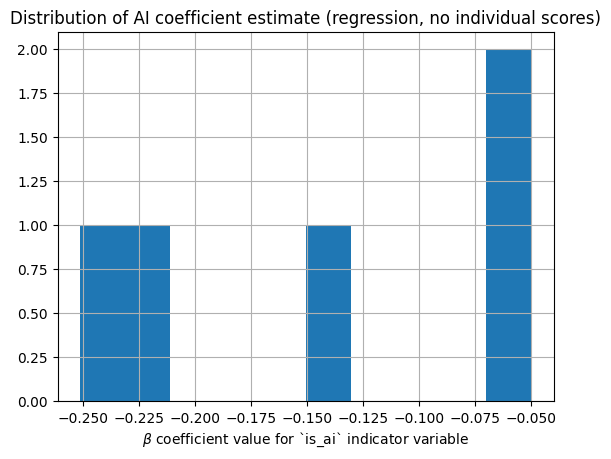

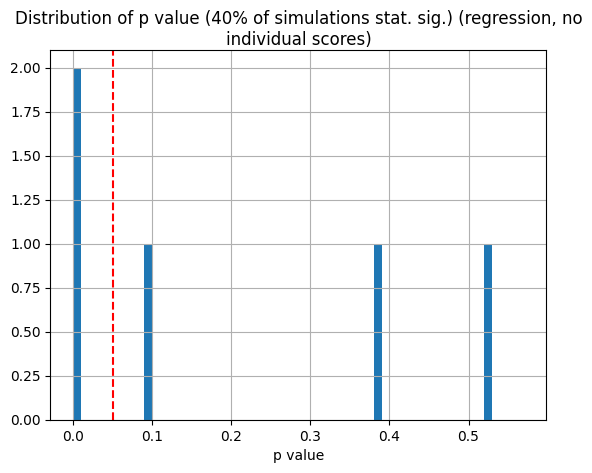

binomial


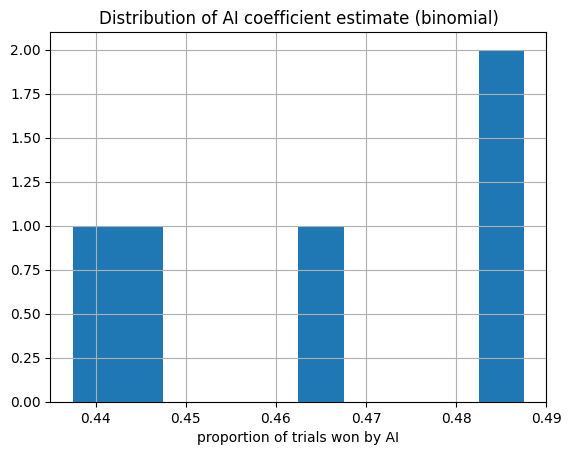

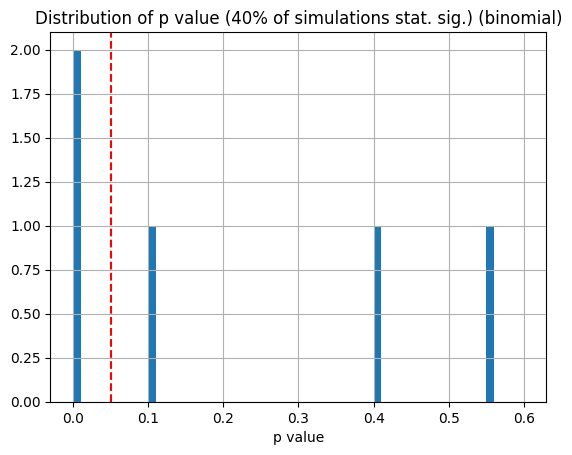

In [55]:
test_df = run_simulation_n_times(
    'test', 
    N = 5, 
    plot=True, 
    do_bayes_individual_effects=False,
    do_bayes_no_individual_effects=False
    # Model_ABILITIES = [0.9,0.9,0.9,0.9], 
    # avg_participant_skill=5
    # N_PARTICIPANTS=40
)

There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)


[(np.float64(0.78), np.float64(0.78)), (np.float64(0.88), np.float64(0.88)), (np.float64(0.98), np.float64(0.98)), (np.float64(0.94), np.float64(0.94)), (np.float64(0.98), np.float64(0.98))]


<Axes: >

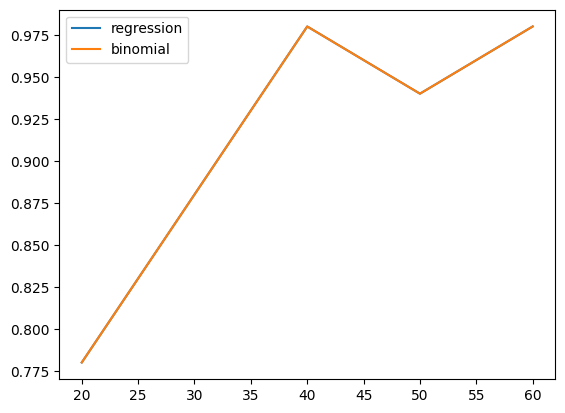

In [ ]:
def test_participant_num(N):
    return run_simulation_n_times('test', N=50, plot=False, Model_ABILITIES = [0.9]*4, avg_participant_skill=5, N_PARTICIPANTS=N)

res = [test_participant_num(N) for N in [20, 30, 40, 50, 60]]
print(res)
    
pd.DataFrame(res, columns=['regression', 'binomial'], index = [20, 30, 40, 50, 60]).plot()


- test for non-difference
- seperability
- more complicated model

Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


<Axes: >

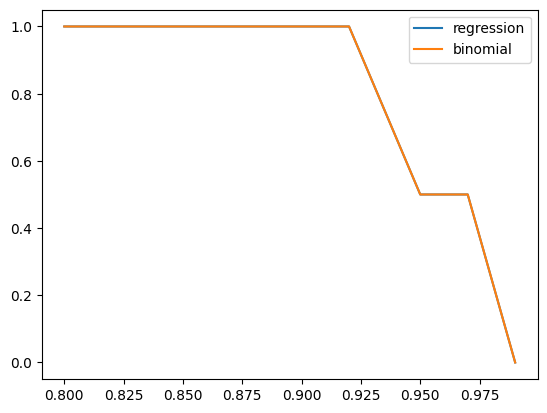

In [ ]:
def test_model_skill(skill):
    return run_simulation_n_times('test', N=2, plot=False, Model_ABILITIES = [skill]*4, avg_participant_skill=5, N_PARTICIPANTS=40)

skills = [0.8, 0.85, 0.9, 0.92, 0.95, 0.97, 0.99]

res_model_skill = [test_model_skill(skill) for skill in skills]
# print(res_model_skill)

pd.DataFrame(res_model_skill, columns=['regression', 'binomial'], index = skills).plot()

There were 20 warnings (use warnings() to see them)


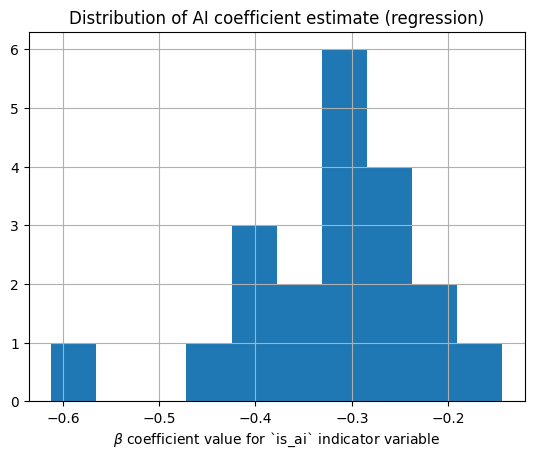

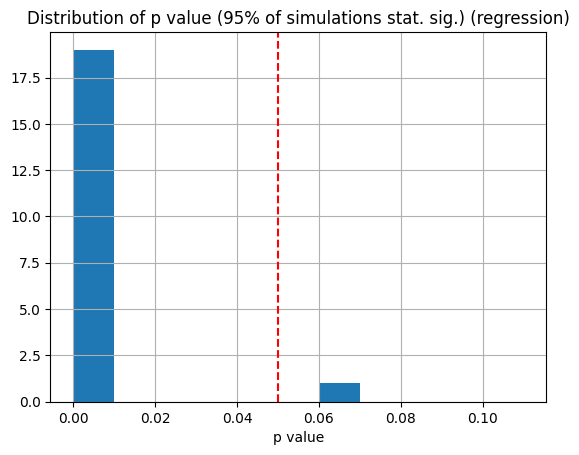

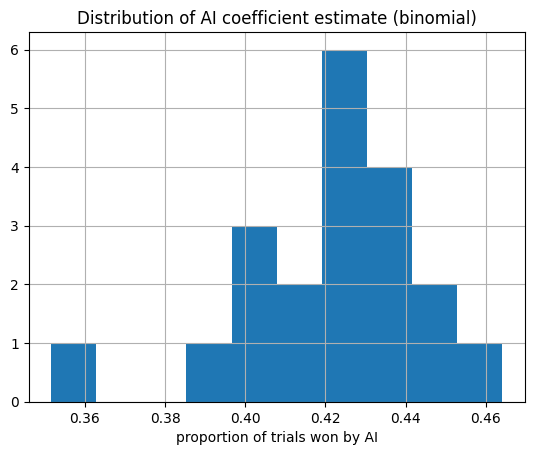

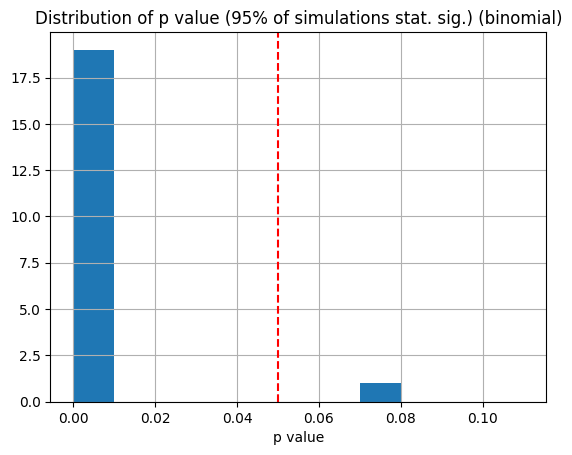

In [ ]:

cProfile.run(
    """run_simulation_n_times('test', N = 20, Model_ABILITIES = [0.9,0.9,0.9,0.9], avg_participant_skill=5, N_PARTICIPANTS=40)""", 
    'profiling.prof'
)

## Bayesian approach for small data when estimating fixed individual effects

# Calibration

0.99 4.6000000000000005
0.9 2.2
0.75 1.1
0.55 0.2


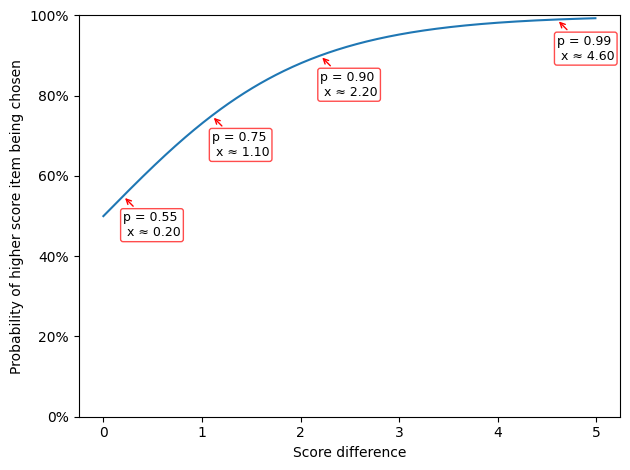

In [ ]:
x = np.arange(0, 5, 0.01)
y = 1 - score_diff_to_probability(x) 

probs_of_interest = [0.99, 0.9, 0.75, 0.55]
for p in probs_of_interest:
    idx = (np.abs(y - p)).argmin()
    print(p, x[idx])
# if the diff is positive, it means that B has better score than A, (so p(A>B) < 0.5) . 
# So we take 1 - {this function} for the purposes of this calibration, which gives p(B>A)
plt.plot(x, y)
for p in probs_of_interest:
    idx = (np.abs(y - p)).argmin()
    x_val = x[idx]

    # Vertical & horizontal guides
    # plt.axvline(x_val, color='red', linestyle='--', lw=1, alpha=0.7)
    # plt.axhline(p, color='gray', linestyle=':', lw=1, alpha=0.4)

    # Annotate with arrow
    plt.annotate(
        f'p = {p:.2f}\n x ≈ {x_val:.2f}',
        xy=(x_val, p),
        xytext=(x_val, p - 0.1),
        textcoords='data',
        arrowprops=dict(arrowstyle='->', color='red', lw=1),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.7)
    )
plt.ylim((0,1))
plt.xlabel('Score difference')
plt.ylabel('Probability of higher score item being chosen')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.tight_layout()

In [ ]:
comparisons = pd.Series([
    (0, 1),
    (0.5, 1),
    (0.75, 1),
    (0.9, 1),
    (0.95, 1)
])
skill = 5
comparisons.map(lambda el: score_diff_to_probability(skill * (el[0] - el[1])))

0    0.993307
1    0.924142
2    0.777300
3    0.622459
4    0.562177
dtype: float64

# Further notes

To do:
- no repeats within trials 
- sampling without replacement 
- use same trial block format as in experimental design (done)
- think about what characteristicness per artist is meant to represent (done)
- how to calibrate participant baseline skill for simulations (roughly done, see calibration)

## What simulations do we want to run?

### Sense checks:
- Increasing the # of participants should increase power
- Increasing the skill of participants should increase power
- Reducing avg. characteristicness of artists should increase power
- Reducing the mimicing ability of Models should reduce power
- Maintaining average Model ability but increasing spread should decrease power

### Calibration:
- Need to calibrate how skill influences probability. Maybe fix AI characteristicness at 0.6 and human at 0.7 (so it's a fixed 0.1 diff), then vary

# Other methods:
- Bradley-Terry model w/ regression: done
- Simple method: proportion of wins to AI, run a chi squared test for independence

### Specification of Bradley-Terry model:

$$P(A > B) = \frac{1}{1 + e^{\lambda_B - \lambda_A}},$$
where
$$\lambda_A = \beta_A +  \beta_0 \cdot is\_ai_A + \beta_1 \cdot Model_1 + \cdots + \beta_m \cdot Model_{m}  + \beta_{m+1} \cdot is\_anachronistic + \epsilon, \\ \epsilon \sim N(0, \theta)$$


$$\lambda_A = \beta_A$$

$$\lambda_A = \beta_0 \cdot is\_ai_A  $$

- Improve Bayesian stuff (faster, better convergence)
- multinomial regression / whatever other approaches make sense
- look at 2AFC papers in: PNAS, Nature, Cognitive Science
- **Experimentology** <-- read

Specification of model:
$$ logit(P(i > j)) \sim (c_j + A ) - (c_i + A) $$
where $i$ and $j$ are different images. Note that $\sim$ indicates that the LHS is modelled by a linear combination of the RHS variables plus random noise.

And a more complex model:

$$ logit(P(i > j)) \sim (c_j + A_x ) - (c_i + A_y ) $$

where $x$ and $y$ are AI models. 

Incorporating entanglement:

$$ logit(P(i > j)) \sim (c_j + A_x + W_x ) - (c_i + A_y + W_y ) $$

where $W_x$ and $W_y$ are 1 if the subject is anachronistic

probability of one ArtImage being chosen: 

$$P(A > B) := \frac{e^{\lambda \cdot p_A} }{ e^{\lambda \cdot p_A} + e^{\lambda \cdot p_B} }  $$

where $S_x$ is the skill of the participant $x$. If $S_x$ is 

$$ P(A > B) := \frac{1}{1 + e^{\lambda \cdot ( p_B - p_A) }}  $$